In [1]:
from DSA.dmd import DMD
from DSA.simdist import SimilarityTransformDist
import torch
import numpy as np
from sklearn.manifold import MDS
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [25]:
x1 = torch.rand([200, 10000, 2])
x2 = torch.rand([200, 10000, 2])

nmodels = 3
n_delays = 50
delay_interval = 20
rank = 30

models = []
model_types = []

for i, x in enumerate([x1, x2]):
    for n in tqdm(range(nmodels)):  
        print(x.shape)
        dmd = DMD(x,n_delays=n_delays,rank=rank,delay_interval=delay_interval,device='cpu')
        dmd.fit()
        Ai = dmd.A_v #extract DMD matrix
        models.append(Ai.numpy())
        model_types.append(f'model {i}')

  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([200, 10000, 2])


 33%|███▎      | 1/3 [00:47<01:34, 47.47s/it]

torch.Size([200, 10000, 2])


 67%|██████▋   | 2/3 [01:31<00:45, 45.52s/it]

torch.Size([200, 10000, 2])


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([200, 10000, 2])


 33%|███▎      | 1/3 [00:58<01:56, 58.21s/it]

torch.Size([200, 10000, 2])


 67%|██████▋   | 2/3 [01:53<00:56, 56.74s/it]

torch.Size([200, 10000, 2])


100%|██████████| 3/3 [02:50<00:00, 56.71s/it]


In [23]:
nmodels_tot = len(models)

sims_dmd = np.zeros((nmodels_tot,nmodels_tot))
sims_mtype = np.zeros((nmodels_tot,nmodels_tot))
#notice how we are initializing the similarity transform separately here
comparison_dmd = SimilarityTransformDist(device='cpu',iters=2000,lr=1e-3)

for i,mi in enumerate(models):
    for j,mj in enumerate(models):
        smtype = int(model_types[i] == model_types[j])
        sims_mtype[i,j] = sims_mtype[j,i] = smtype
        if i == j:
            sims_mtype[i,i] = 2
        if j < i:
            continue
        sdmd = comparison_dmd.fit_score(mi,mj)
        print(i,j,sdmd)

        sims_dmd[i,j] = sims_dmd[j,i] = sdmd


0 0 0.003504079
0 1 0.0040412494
0 2 0.005167489
0 3 0.021842495
0 4 0.022884695
0 5 0.020727895
1 1 0.0044080773
1 2 0.004394535
1 3 0.022767177
1 4 0.023693519
1 5 0.022175629
2 2 0.0042286427
2 3 0.024127312
2 4 0.020979438
2 5 0.023302851
3 3 0.0049795164
3 4 0.0039517637
3 5 0.0044080773
4 4 0.003966818
4 5 0.0054700645
5 5 0.0049914722


/home/jsalle/.conda/envs/p11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jsalle/.conda/envs/p11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jsalle/.conda/envs/p11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jsalle/.conda/envs/p11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

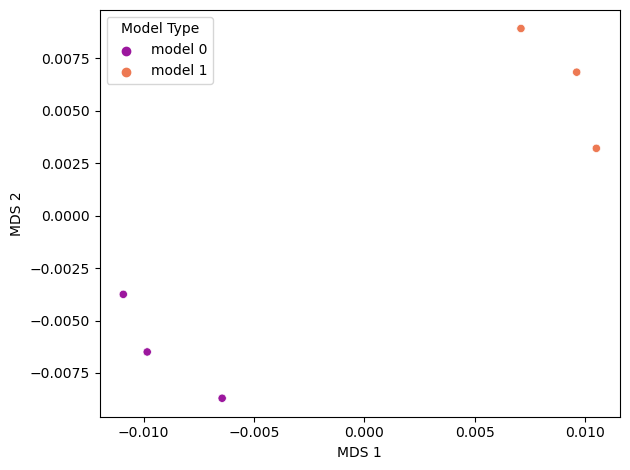

In [24]:
df = pd.DataFrame()
df['Model Type'] = model_types
lowd_embedding = MDS(dissimilarity='precomputed').fit_transform(sims_dmd)
df[f"DMD:0"] = lowd_embedding[:,0] 
df[f"DMD:1"] = lowd_embedding[:,1]
    

fig,ax = plt.subplots(1,1,sharex=True,sharey=True)
palette = 'plasma'
sns.scatterplot(data=df,x=f"DMD:0",y=f"DMD:1",hue="Model Type",ax=ax,palette=palette)
ax.set_xlabel(f"MDS 1")
ax.set_ylabel(f"MDS 2")
plt.tight_layout()

# Hyperparameter Tuning

In [2]:
from transformer_lens import utils, HookedTransformer, ActivationCache, patching, evals
from transformer_lens.hook_points import HookPoint
from transformer_lens.utils import get_act_name
from tqdm import tqdm
import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
from jaxtyping import Int, Float
from typing import List, Optional, Tuple
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
from einops import repeat
import pickle
import argparse
import os.path
import multiprocessing

from DSA.dsa import DSA
from DSA.dmd import DMD
from DSA.simdist import SimilarityTransformDist
from sklearn.manifold import MDS

/home/jsalle/.conda/envs/p11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#torch.set_grad_enabled(False)

# List all available GPUs
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")

else:
    print("CUDA is not available. Listing CPUs instead.", multiprocessing.cpu_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_model(model_name: str = 'gpt2-small', 
              checkpoint_index: int = None,
              device=None) -> HookedTransformer:
    """
    Loads source or target model.
    Pythia models have 154 checkpoints.

    model_name: ['gpt2-small', 'pythia-6.9b'] see transformer_lens list
    """
    if 'model_name' != 'bert-base-cased':
        return HookedTransformer.from_pretrained(model_name, 
                                             checkpoint_index=checkpoint_index,
                                             device=device)
    else:
        return HookedTransformer.from_pretrained(model_name, device=device)


def store_activations_in_array(model: HookedTransformer,
                               prompt: str,
                               activation_type: str = 'resid_pre'):

    _, cache = model.run_with_cache(prompt)
    
    x = torch.zeros([1, model.cfg.n_layers, model.cfg.d_model])

    for l in range(0, model.cfg.n_layers):
        activations_last_token = cache[activation_type, l][0, -1, :]
        x[0, l, :] = activations_last_token

    return x # shape: [n_layers, d_model]

CUDA is not available. Listing CPUs instead. 48


## BERT activations

In [4]:
from transformers import BertTokenizer, BertModel


prompt = "When John and Mary went to the store, John gave a bottle of milk to "

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

bert_activations = torch.zeros((1, model.config.num_hidden_layers, model.config.hidden_size))

def get_layer_hook(layer_num):
    def hook(module, input, output):
        bert_activations[0, layer_num, :] = output[0][0, -1, :]
    return hook

# Register hooks for each BertLayer
for i, layer in enumerate(model.encoder.layer):
    hook = layer.register_forward_hook(get_layer_hook(i))

# Forward pass through the model
with torch.no_grad():
    encoded_input = tokenizer(prompt, return_tensors='pt')
    output = model(**encoded_input)

# Access the output of a specific layer, e.g., layer 5
print(bert_activations.shape)

torch.Size([1, 12, 768])


In [5]:
models_names = ['gpt2-small', 'gpt2-medium', 'pythia-160m', 'pythia-410m']#, 'pythia-1b', 'bert-base-cased', 'solu-12l', 'mistral-7b']
#models_names = models_names[0:2]
#print(models_names)

activations = []
model_types = []
models = []

for i, model_name in enumerate(models_names):
    print(f'Model number {i}/{len(models_names)-1}')
    model = get_model(model_name, device=device)
    x = store_activations_in_array(model, prompt=prompt)
    activations.append(x)
    model_types.append(f'{model_name}')

# bert-base-uncased
print("Add bert-base-uncased")
activations.append(bert_activations)
model_types.append('bert-base-uncased')
models_names.append('bert-base-uncased')

Model number 0/3


Loaded pretrained model gpt2-small into HookedTransformer
Model number 1/3
Loaded pretrained model gpt2-medium into HookedTransformer
Model number 2/3


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-160m into HookedTransformer
Model number 3/3


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-410m into HookedTransformer
Add bert-base-uncased


In [6]:
nmodels = 1
n_delays = 5
delay_interval = 1
rank = 6

for x in activations:
    x = x[0,:,:] # x.shape [timepoints, dimensions]
    print('x.shape', x.shape)
    dmd = DMD(x,n_delays=n_delays,rank=rank,delay_interval=delay_interval,device=device, verbose=True)
    dmd.fit()
    Ai = dmd.A_v #extract DMD matrix
    models.append(Ai.numpy())

nmodels_tot = len(models)

x.shape torch.Size([12, 768])
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
H torch.Size([8, 3840])
SVD complete!
recalc_rank
Computing least squares fits to HAVOK DMD ...
havok: self.Vt_minus[:, :self.rank] torch.Size([7, 6])
self.Vt_plus[:, :self.rank] torch.Size([7, 6])
addition torch.Size([6, 6])
Least squares complete! 

x.shape torch.Size([24, 1024])
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
H torch.Size([20, 5120])
SVD complete!
recalc_rank
Computing least squares fits to HAVOK DMD ...
havok: self.Vt_minus[:, :self.rank] torch.Size([19, 6])
self.Vt_plus[:, :self.rank] torch.Size([19, 6])
addition torch.Size([6, 6])
Least squares complete! 

x.shape torch.Size([12, 768])
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
H torch.Size([8, 3840])
SVD complete!
recalc_rank
Computing least squares fits to HAVOK DMD ...
havok: self.Vt_minus[:, :self.rank] torch.Siz

0 0 0
0 1 0.9454356
0 2 0.10483411
0 3 1.0626223
0 4 0.26023856
1 1 0
1 2 0.98439234
1 3 0.21063977
1 4 0.7785551
2 2 0.00034526698
2 3 1.099241
2 4 0.31097683
3 3 0.0
3 4 0.90272695
4 4 0.0


/home/jsalle/.conda/envs/p11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jsalle/.conda/envs/p11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jsalle/.conda/envs/p11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jsalle/.conda/envs/p11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

Text(0, 0.5, 'MDS 2')

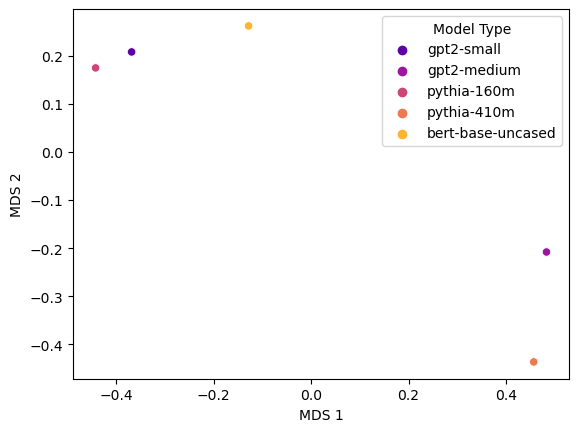

In [7]:
sims_dmd = np.zeros((nmodels_tot,nmodels_tot))
sims_mtype = np.zeros((nmodels_tot,nmodels_tot))
#notice how we are initializing the similarity transform separately here
comparison_dmd = SimilarityTransformDist(device=device,iters=2000,lr=1e-3)

for i,mi in enumerate(models):
    for j,mj in enumerate(models):
        smtype = int(model_types[i] == model_types[j])
        sims_mtype[i,j] = sims_mtype[j,i] = smtype
        if i == j:
            sims_mtype[i,i] = 2
        if j < i:
            continue
        sdmd = comparison_dmd.fit_score(mi,mj)
        print(i,j,sdmd)

        sims_dmd[i,j] = sims_dmd[j,i] = sdmd


df = pd.DataFrame()
df['Model Type'] = model_types
lowd_embedding = MDS(dissimilarity='precomputed').fit_transform(sims_dmd)
df[f"DMD:0"] = lowd_embedding[:,0] 
df[f"DMD:1"] = lowd_embedding[:,1]

with open("data/similarity_analysis_of_context_mds.pkl", 'wb') as file:
    pickle.dump(df, file)
    

fig,ax = plt.subplots(1,1,sharex=True,sharey=True)
palette = 'plasma'
sns.scatterplot(data=df,x=f"DMD:0",y=f"DMD:1",hue="Model Type",ax=ax,palette=palette)
ax.set_xlabel(f"MDS 1")
ax.set_ylabel(f"MDS 2")

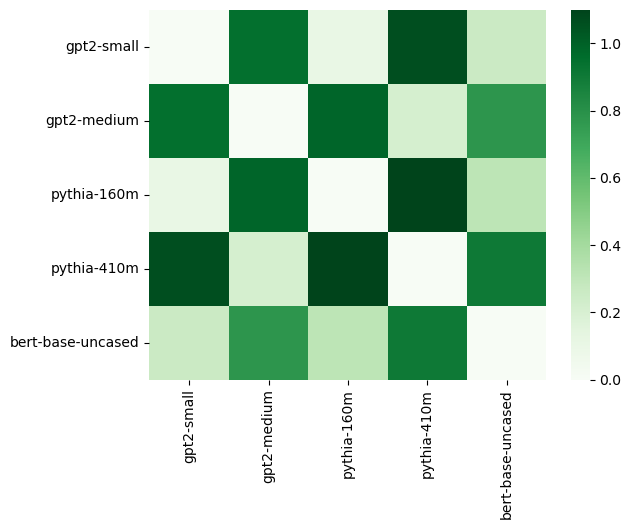

In [8]:
palette = "Greens"
sns_fig = sns.heatmap(sims_dmd, yticklabels=models_names, xticklabels=models_names, cmap=palette)
plt.yticks(rotation=0) 
sns_fig.figure.savefig('figures/test_dmd_heatmap.png')

In [122]:
n_params = []

for m in models_names:
    if m == "bert-base-uncased":
        n_params.append(85*10**6)
    else:
        n_params.append(HookedTransformer.from_pretrained(m).cfg.n_params)

print(n_params)

Loaded pretrained model gpt2-small into HookedTransformer
Loaded pretrained model gpt2-medium into HookedTransformer


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-160m into HookedTransformer


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-410m into HookedTransformer
[84934656, 301989888, 84934656, 301989888, 85000000]
